# Preparation

<b>Load Libraries</b>

In [43]:
# data structure
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
##
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 19)
sns.set_style('whitegrid')
sns.set_theme('notebook')

# cluser analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

<b>Load Dataset</b>

In [3]:
# dataset: xlsx
df_base_xlsx = pd.read_excel('../resource/data/raw.xlsx')
df_base_xlsx.to_csv('../resource/data/raw.csv', index=False)

In [3]:
# dataset: csv
df_base = pd.read_csv('../resource/data/raw.csv')

# 1. Data Wrangling

<b>General</b>

In [4]:
# clone 
df_cleaned = df_base.copy()

In [5]:
# shape
df_base.shape

(541909, 8)

In [6]:
# head
df_base.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# tail
df_base.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [8]:
# info
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
# drop irrelevant columns
try:
    df_cleaned.drop(['StockCode'], inplace=True, axis=1)
except:
    print('Check columns\' name again')

In [10]:
# stripping
##
df_cleaned.columns = [name.strip() for name in df_cleaned.columns.tolist()]
num_cols = df_cleaned.select_dtypes(np.number).columns.tolist()
cat_cols = df_cleaned.select_dtypes('object').columns.tolist()
##
df_cleaned[cat_cols] = df_base[cat_cols].astype(str).map(lambda x: x.strip())

In [11]:
# null strings
names = (df_cleaned[cat_cols] == '').sum(axis=0).to_frame('counts')\
    .query("counts != 0").index.tolist()
print(f'Number of columns with null strings: {len(names)}\n{names}')

Number of columns with null strings: 0
[]


In [12]:
# single-value columns
names = df_cleaned.nunique().to_frame('nunique')\
    .query("nunique == 1").index.tolist() 
print(f'Total single-value columns: {len(names)} \n{names}')

Total single-value columns: 0 
[]


In [13]:
# spelling
df_cleaned[cat_cols].agg(lambda x: print(f'{x.name}: {x.unique()}') if len(np.unique(x)) <= 40 else print(f'{x.name}:Too many values to check manually'))

InvoiceNo:Too many values to check manually
Description:Too many values to check manually
InvoiceDate:Too many values to check manually
Country: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


InvoiceNo      None
Description    None
InvoiceDate    None
Country        None
dtype: object

<b>Additional</b>

In [14]:
# missing values
names = df_cleaned.isnull().sum(axis=0).to_frame('count')\
    .query("count != 0").index.tolist()
print(f'Number of columns with missing values: {len(names)} \n{names}')

Number of columns with missing values: 1 
['CustomerID']


In [15]:
# missing values
df_cleaned.dropna(axis=0, inplace=True)

In [16]:
# duplications
counts = df_cleaned.duplicated().sum()
print(f'Total duplications: {counts}')

Total duplications: 5269


In [17]:
# finalize
df_cleaned.to_csv('../resource/data/cleaned.csv', index=False)

<b>Additional - Cluster Analysis</b>

In [18]:
# remove those cancelled orders
mask = df_cleaned['InvoiceNo'].map(lambda x: True if str(x).startswith('C') else False)
df_cluster_analysis = df_cleaned.copy()[~mask].set_index('CustomerID')
print(f'Total cancelled orders: {mask.sum()}')

Total cancelled orders: 8905


In [19]:
# remove irrelavant columns
try:
    df_cluster_analysis.drop(['InvoiceNo'], inplace=True, axis=1)
except:
    print('Check the name of columms again')

In [20]:
# re-format 
df_cluster_analysis['InvoiceDate'] = pd.to_datetime(df_cluster_analysis['InvoiceDate'])\
    .dt.strftime('%Y-%m-%d')
df_cluster_analysis['InvoiceDate'] = pd.to_datetime(df_cluster_analysis['InvoiceDate'])

In [21]:
# frequency
freq = df_cluster_analysis.groupby('CustomerID', sort=True)['InvoiceDate'].count()\
    .to_frame('freq')
freq.head()

,freq
CustomerID,
12346.0,1
12347.0,182
12348.0,31
12349.0,73
12350.0,17


In [22]:
# monetary
monetary = (df_cluster_analysis['Quantity']*df_cluster_analysis['UnitPrice'])\
    .groupby('CustomerID', sort=True).sum().to_frame('monetary')
monetary.head()

,monetary
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [23]:
# recency
recency = df_cluster_analysis.groupby('CustomerID')['InvoiceDate'].transform('max')\
    .to_frame('recency').reset_index().\
        drop_duplicates(subset=['CustomerID']).set_index('CustomerID').sort_index(ascending=True)
recency['recency'] = (recency['recency'] - recency['recency'].min()).dt.days
recency.head()

,recency
CustomerID,
12346.0,48
12347.0,371
12348.0,298
12349.0,355
12350.0,63


In [24]:
# recency - frequency - monetary
rfm = pd.concat([recency, freq, monetary], axis=1)
rfm.head()

,recency,freq,monetary
CustomerID,,,
12346.0,48,1,77183.60
12347.0,371,182,4310.00
12348.0,298,31,1797.24
12349.0,355,73,1757.55
12350.0,63,17,334.40


In [25]:
# finalize
rfm.to_csv('../resource/data/rfm.csv', index=False)

<b>Additional - Corhort Analysis</b>

In [26]:
# remove irrelavant columns
df_cohort_analysis = df_cleaned.copy()
##
try:
    df_cohort_analysis.drop(['InvoiceNo'], inplace=True, axis=1)
except:
    print('Check the name of columns again')

In [27]:
# re-format
df_cohort_analysis['InvoiceDate'] = pd.to_datetime(df_cohort_analysis['InvoiceDate']).dt.strftime('%Y-%m-01')
df_cohort_analysis['InvoiceDate'] = pd.to_datetime(df_cohort_analysis['InvoiceDate'])
df_cohort_analysis.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [28]:
# cohort month
df_cohort_analysis['cohort_month'] = df_cohort_analysis.groupby('CustomerID')['InvoiceDate'].transform('min')
df_cohort_analysis.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cohort_month
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,2010-12-01
1,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12-01
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,2010-12-01
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12-01
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12-01


In [29]:
# cohort index
def calculate_cohort_idx(df: pd.DataFrame, current_date: str, cohort_month: str):
    yrs_diff = df[current_date].dt.year.astype(int) - df[cohort_month].dt.year.astype(int)
    months_diff = df[current_date].dt.month.astype(int) - df[cohort_month].dt.month.astype(int)
    total_months_diff = yrs_diff*12 + months_diff

    return total_months_diff

df_cohort_analysis['cohort_idx'] = calculate_cohort_idx(df_cohort_analysis, 'InvoiceDate', 'cohort_month')
df_cohort_analysis['cohort_month'] = df_cohort_analysis['cohort_month'].astype(str)
df_cohort_analysis.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cohort_month,cohort_idx
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,2010-12-01,0
1,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12-01,0
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,2010-12-01,0
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12-01,0
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12-01,0


In [32]:
# finalize
df_cohort_analysis.to_csv('../resource/data/cohort.csv', index=False)

# 2. Cohort Analysis

<b>Preparation</b>

In [33]:
# dataset
df_cohort_analysis = pd.read_csv('../resource/data/cohort.csv')

<b>Evaluation</b>

In [34]:
# cohort
cohort = df_cohort_analysis.groupby(['cohort_month', 'cohort_idx'])['CustomerID'].nunique()\
    .to_frame('usr_counts').sort_index()
cohort['retention_rate'] = cohort['usr_counts'] / cohort.groupby(['cohort_month'])['usr_counts'].transform('max')
cohort.head(5)

usr_counts  retention_rate
cohort_month cohort_idx                            
2010-12-01   0                  948        1.000000
             1                  362        0.381857
             2                  317        0.334388
             3                  367        0.387131
             4                  341        0.359705

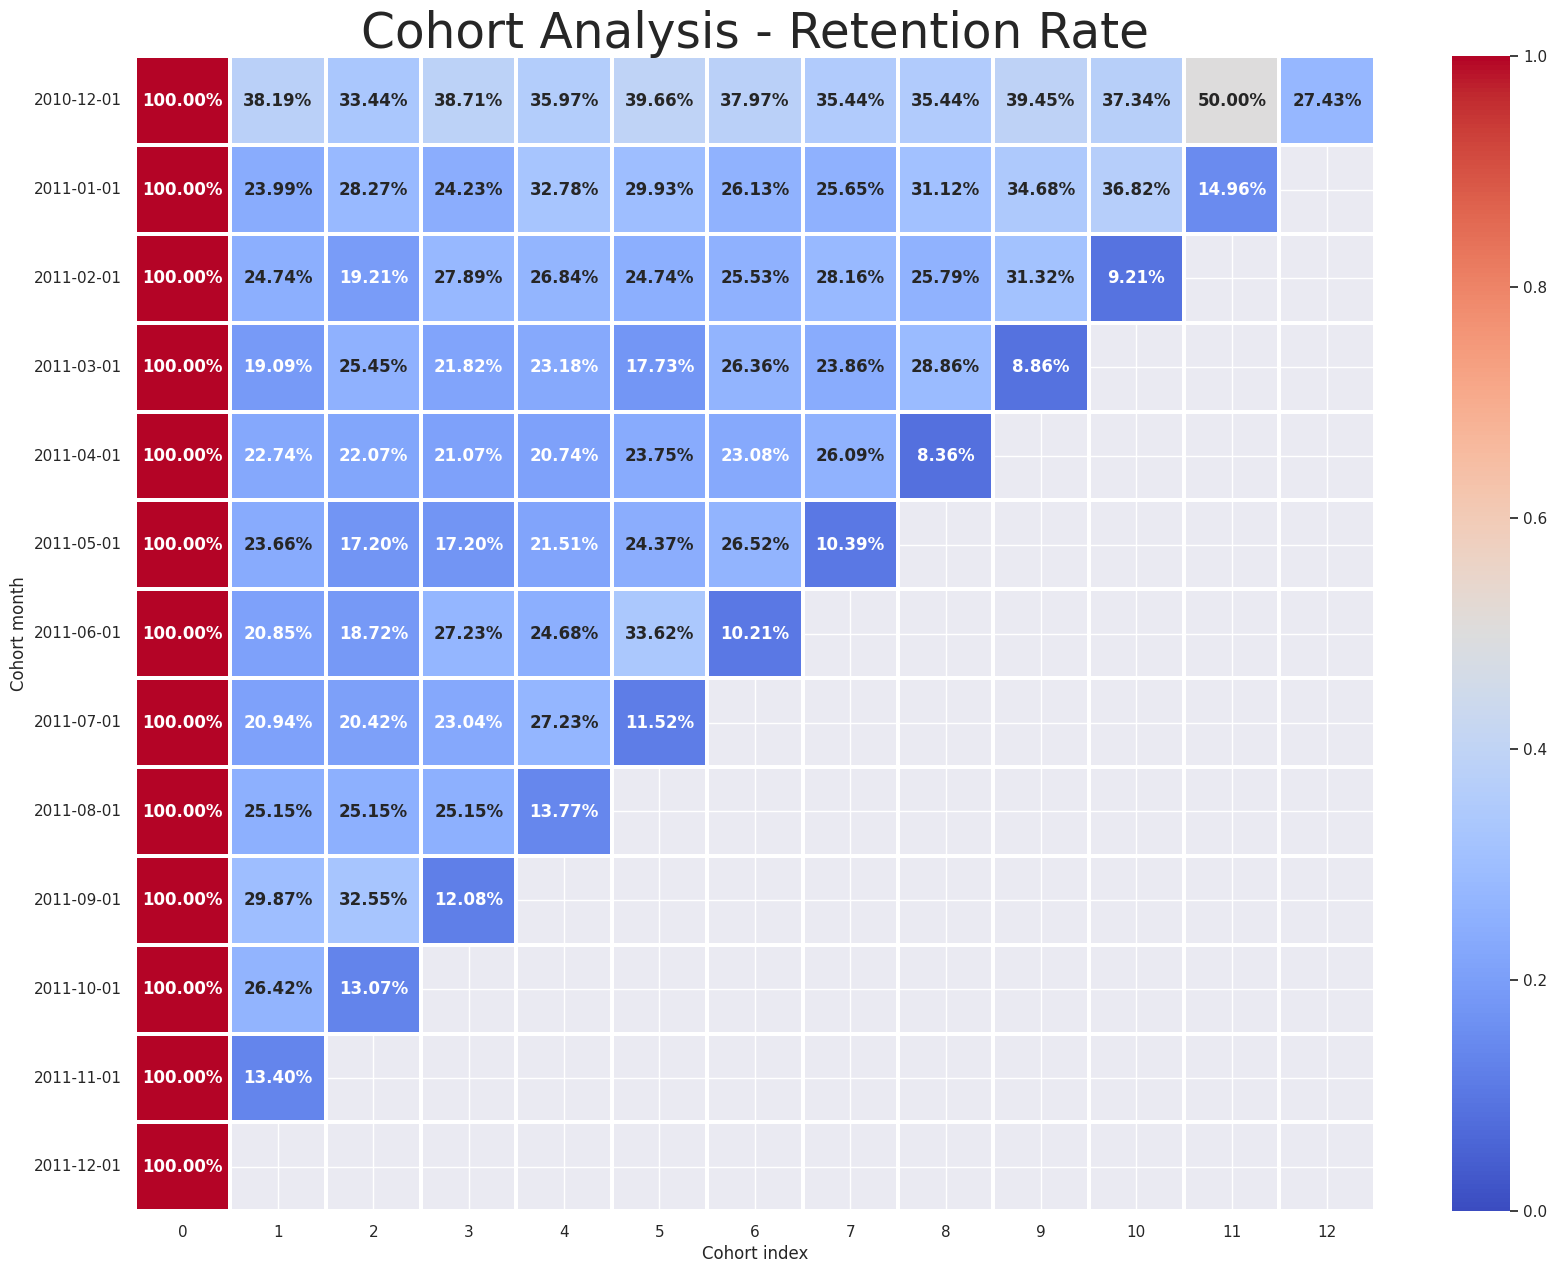

In [44]:
# heatmap
data_to_plot = cohort.pivot_table(index='cohort_month', columns='cohort_idx', values='retention_rate')
##
fig, ax = plt.subplots(figsize=(20, 15))
g = sns.heatmap(data_to_plot, vmin=0, vmax=1,
                annot=True, fmt='.2%', annot_kws=dict(weight='bold'), linewidths=1.5,
                cmap='coolwarm', ax=ax)
g.set_ylabel('Cohort month')
g.set_xlabel('Cohort index')
g.set_title('Cohort Analysis - Retention Rate', 
            fontdict=dict(size=35))
g.axes.tick_params(axis='y', rotation=0)
fig.savefig('../resource/jupyter/image/cohort_analysis_heatmap.png')

plt.show()

# 3. Cluster Analysis

<b>Preparation</b>

In [42]:
# dataset
df_rfm = pd.read_csv('../resource/data/rfm.csv')